<a href="https://colab.research.google.com/github/WIN6996NIM/project-MNIST/blob/main/mnist_fianl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow numpy pillow


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 64s 65ms/step - accuracy: 0.8013 - loss: 0.8355 - val_accuracy: 0.9821 - val_loss: 0.2202
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.9661 - loss: 0.2631 - val_accuracy: 0.9871 - val_loss: 0.1574
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.9730 - loss: 0.2048 - val_accuracy: 0.9883 - val_loss: 0.1449
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.9764 - loss: 0.1817 - val_accuracy: 0.9862 - val_loss: 0.1493
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.9767 - loss: 0.1776 - val_accuracy: 0.9871 - val_loss: 0.1439
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.9778 - loss: 0.1744 - val_accuracy: 0.9896 - val_loss: 0.1317
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.9796 - loss: 0.1688 - val_accuracy: 0.9861 - val_loss: 0.1430
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.9788 - loss: 0.1674 - 

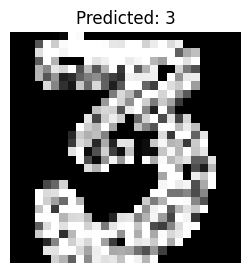

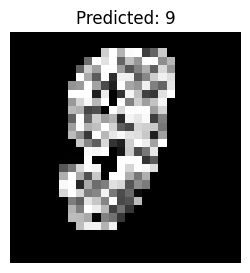

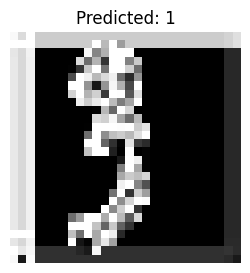

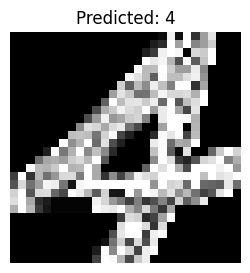

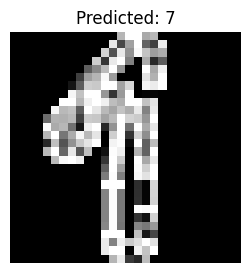

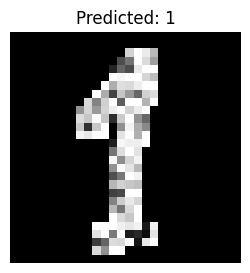

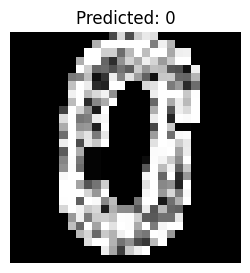

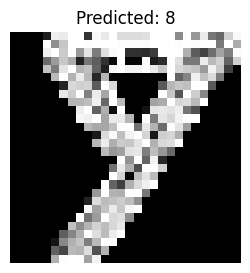

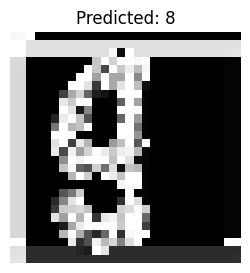

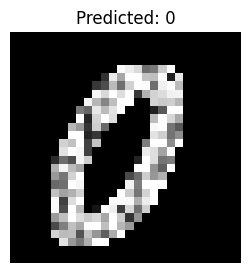

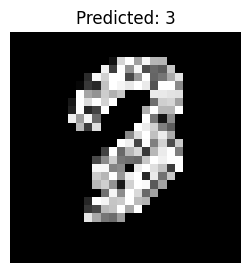

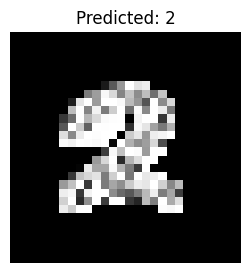

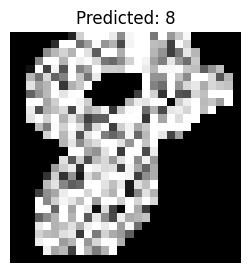

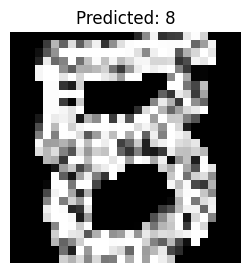

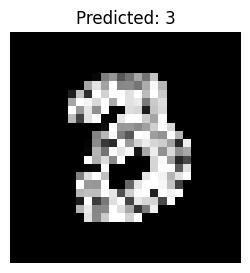

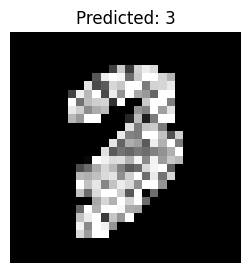

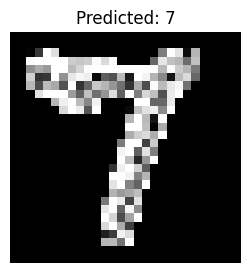

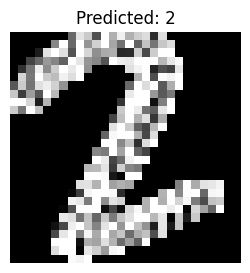

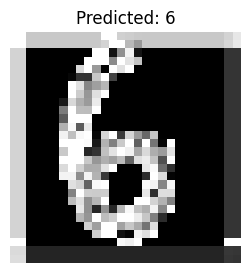

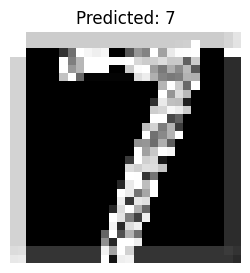

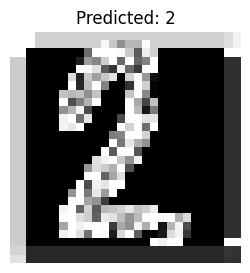

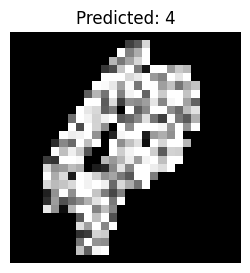

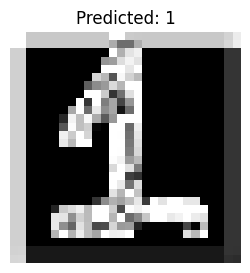

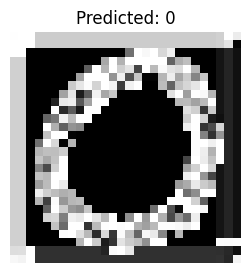

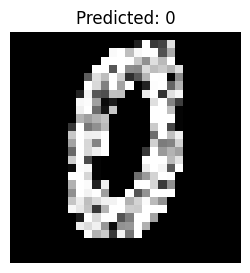

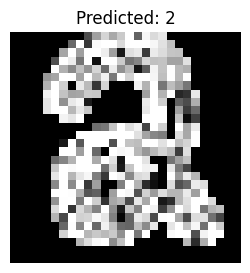

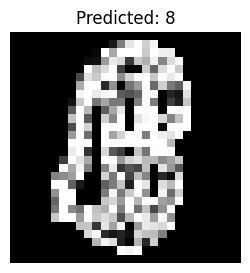

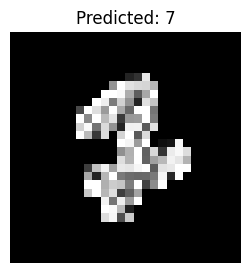

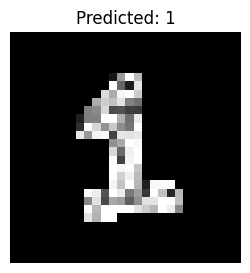

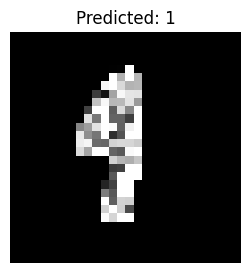

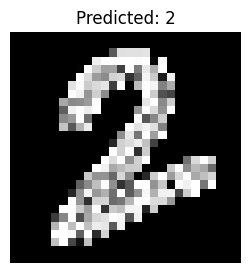

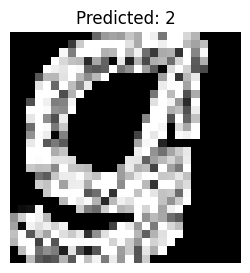

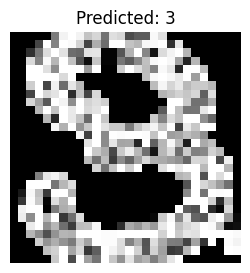

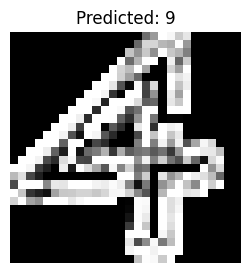

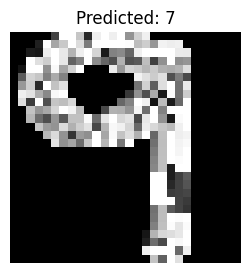

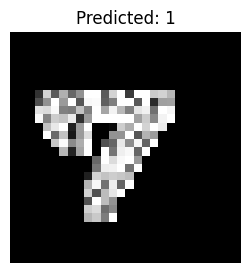

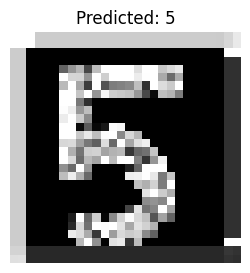

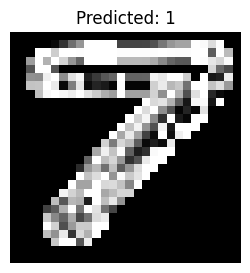

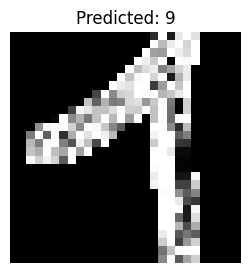

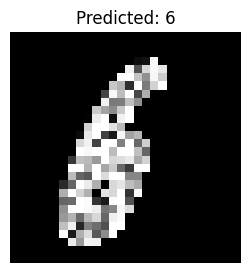

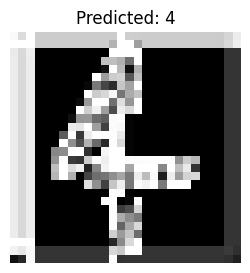

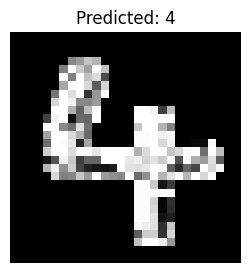

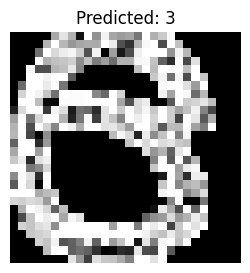

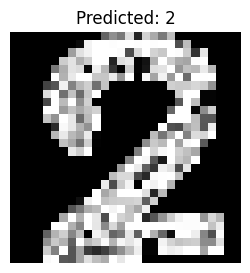

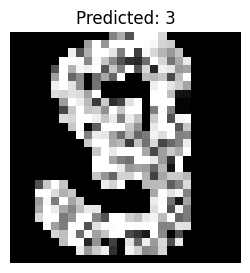

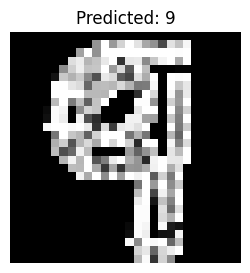

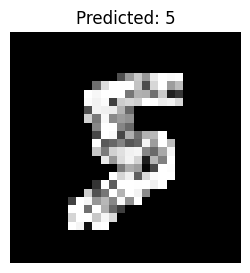

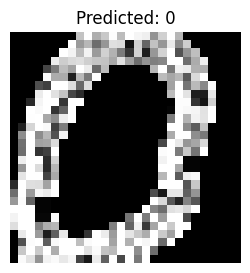

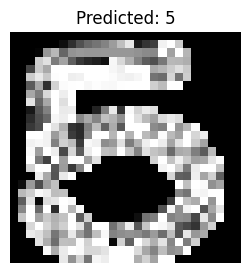

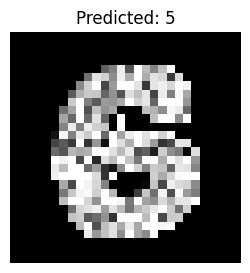

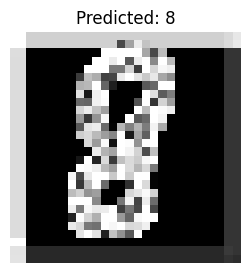

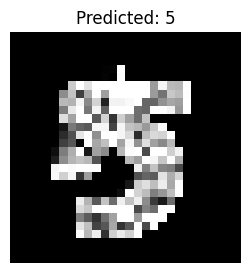

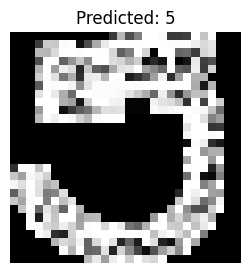

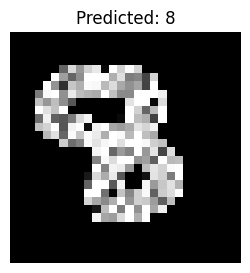

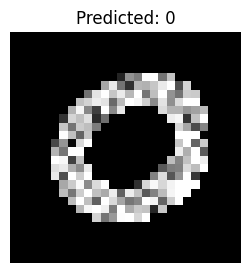

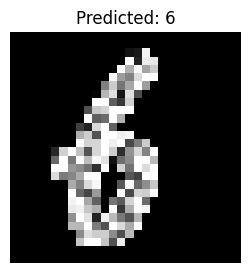

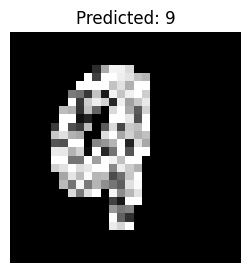

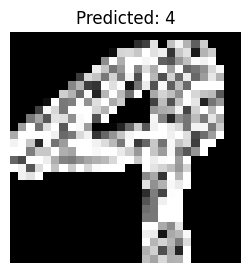

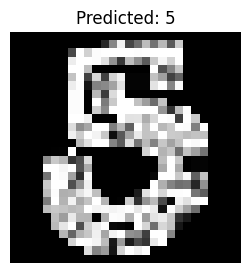

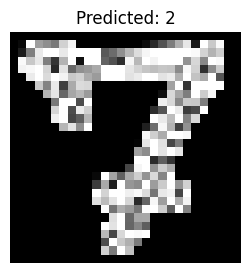

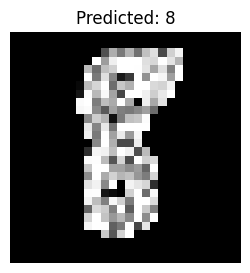

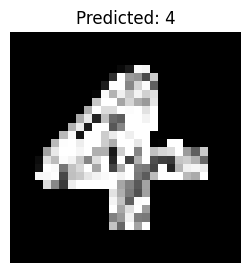

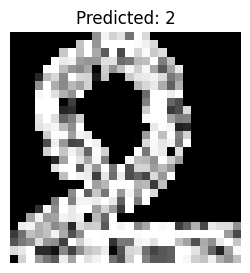

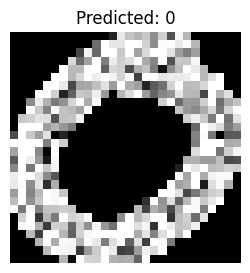

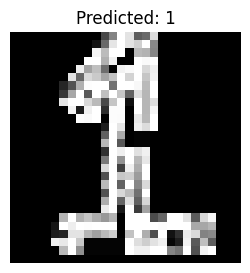

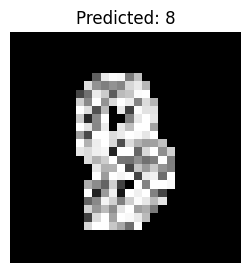

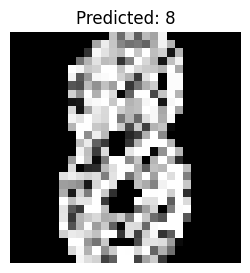

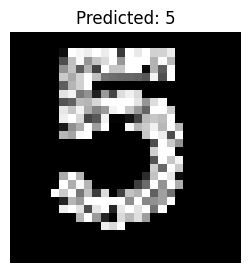

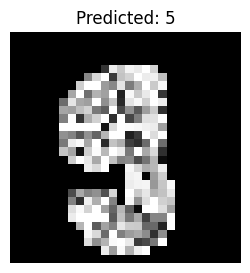

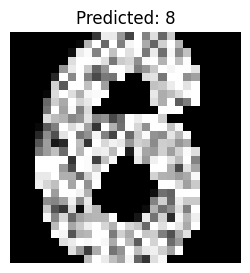

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import time
import os
from PIL import Image, ImageOps, ImageEnhance
from scipy.ndimage import convolve
import re
import matplotlib.pyplot as plt

# โหลด MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize และเพิ่มมิติให้ภาพ
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# สร้างโมเดล CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1),
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')
])

# คอมไพล์โมเดล
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# ใช้ EarlyStopping เพื่อลดการ overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

# ฝึกโมเดล
start_time = time.time()
history = model.fit(train_images, train_labels, epochs=10, batch_size=64,
                    validation_data=(test_images, test_labels), callbacks=[early_stopping])
end_time = time.time()
elapsed_time = end_time - start_time
print(f"เวลาที่ใช้ในการฝึกโมเดล: {elapsed_time:.2f} วินาที")

def prepare_image(image_path, crop=False, sharpen=False, enhance_contrast=False):
    """โหลดและเตรียมภาพจากไฟล์เพื่อใช้ทำนาย พร้อมเพิ่มความคมชัดและเส้นที่ขาด"""
    try:
        img = Image.open(image_path).convert('L')  # แปลงเป็น grayscale
    except Exception as e:
        print(f"ไม่สามารถโหลดภาพจาก {image_path}: {e}")
        return None

    if crop:
        img = ImageOps.invert(img)  # กลับสีให้ตัวเลขเป็นขาว พื้นหลังเป็นดำ
        bbox = img.getbbox()  # หา Bounding Box ของตัวเลข
        if bbox:
            img = img.crop(bbox)  # ตัดขอบเฉพาะส่วนที่มีตัวเลข
        img = ImageOps.invert(img)  # กลับสีคืน

    img = img.resize((28, 28))  # ปรับขนาดให้ตรงกับ MNIST

    # เพิ่มความคมชัด (Sharpen)
    if sharpen:
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(2.0)  # ปรับเพิ่มความคมชัด (ค่า > 1.0 จะทำให้คมชัดขึ้น)

    # ปรับความคมชัดของเส้นด้วย Sobel Filter (Edge Detection)
    if sharpen:
        img_array = np.array(img)
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        img_array_x = convolve(img_array, sobel_x)
        img_array_y = convolve(img_array, sobel_y)
        img_array_edge = np.hypot(img_array_x, img_array_y)  # คำนวณ magnitude ของ edge
        img_array_edge = np.clip(img_array_edge, 0, 255)  # ห้ามให้ค่ามากกว่า 255
        img = Image.fromarray(img_array_edge.astype(np.uint8))

    img = np.array(img) / 255.0  # Normalize ค่าให้อยู่ระหว่าง 0-1
    img = np.expand_dims(img, axis=-1)  # เพิ่มมิติสำหรับช่องสี (grayscale)
    img = np.expand_dims(img, axis=0)  # เพิ่มมิติสำหรับ batch size
    return img

def extract_digit_from_filename(image_path):
    """ดึงตัวเลขจากชื่อไฟล์ เช่น 'd0.jpg' จะได้ '0'"""
    match = re.search(r'\d', image_path)  # หาตัวเลขในชื่อไฟล์
    if match:
        return int(match.group())  # คืนค่าตัวเลขที่เจอ
    return None  # ถ้าไม่เจอตัวเลข

def prepare_and_predict(image_paths, crop=False, sharpen=False):
    prepared_images = [prepare_image(img_path, crop=crop, sharpen=sharpen) for img_path in image_paths]
    return np.concatenate(prepared_images, axis=0) if prepared_images else None

folder_path = 'เทส'  # เปลี่ยนเป็นโฟลเดอร์ที่คุณต้องการทำนาย
image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
               if f.lower().endswith(('.png', '.jpg', '.jpeg', '.jfif', '.webp'))]

if not image_paths:
    print("ไม่พบโฟลเดอร์นี้")
else:
    print(f"พบ {len(image_paths)} ภาพในโฟลเดอร์")

    # เตรียมข้อมูลและทำนายผล
    prepared_images_no_crop = prepare_and_predict(image_paths, crop=False, sharpen=True)
    prepared_images_crop = prepare_and_predict(image_paths, crop=True, sharpen=True)

    # ทำนายผลลัพธ์
    predictions_no_crop = model.predict(prepared_images_no_crop) if prepared_images_no_crop is not None else None
    predictions_crop = model.predict(prepared_images_crop) if prepared_images_crop is not None else None

    # ดึง true labels
    true_labels = np.array([extract_digit_from_filename(p) for p in image_paths])

    predicted_classes_no_crop = np.argmax(predictions_no_crop, axis=1) if predictions_no_crop is not None else None
    predicted_classes_crop = np.argmax(predictions_crop, axis=1) if predictions_crop is not None else None

    # สำหรับการทำนายที่ถูกต้องหรือไม่
    for i, image_path in enumerate(image_paths):
        prepared_img = prepare_image(image_path, sharpen=True)  # ใช้ภาพที่ผ่านการ Resize และเพิ่มความคมชัด
        true_label = true_labels[i]

        if predicted_classes_no_crop[i] == true_label:
            predicted_class = predicted_classes_no_crop[i]
        else:
            predicted_class = predicted_classes_crop[i]

        # แสดงภาพที่ถูก Resize เป็น 28x28
        plt.figure(figsize=(3, 3))
        plt.imshow(prepared_img.squeeze(), cmap='gray')  # ใช้ภาพที่ผ่านการ Resize
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = model.evaluate(test_images  , test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1316947340965271
Test accuracy: 0.9896000027656555


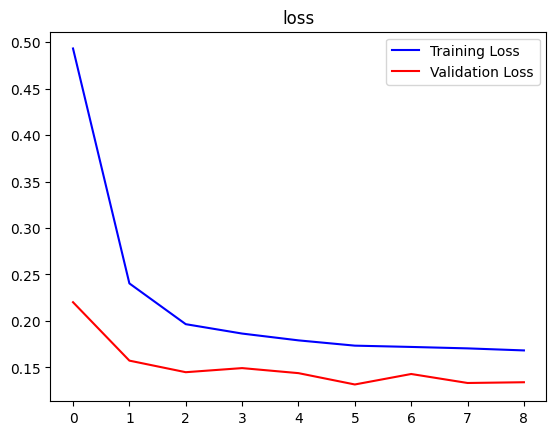

In [ ]:
plt.plot(history.history['loss'],color = 'b', label = 'Training Loss')
plt.plot(history.history['val_loss'],color = 'r', label = 'Validation Loss')
plt.title('loss')
plt.legend()
plt.show()


In [ ]:
y_pred = model.predict(test_images  )
y_pred = np.argmax(y_pred, axis=1)
idx_miss = np.where(y_pred != test_labels)
print(len(idx_miss[0]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
104


In [ ]:
# ดึงค่าจริงจากชื่อไฟล์
true_labels = np.array([extract_digit_from_filename(p) for p in image_paths])

# ตรวจสอบว่าทำนายถูกจากภาพต้นฉบับหรือไม่
correct_no_crop = predicted_classes_no_crop == true_labels

# ตรวจสอบว่าทำนายถูกจากภาพครอปหรือไม่ (เฉพาะกรณีที่ภาพต้นฉบับผิด)
correct_crop = (predicted_classes_crop == true_labels) & (~correct_no_crop)

# รวมผลลัพธ์: ถ้าถูกจากต้นฉบับก็นับเลย ถ้าผิดจากต้นฉบับแต่ถูกจากครอปก็นับ
final_correct = correct_no_crop | correct_crop  # ใช้ OR เพื่อนับกรณีใดกรณีหนึ่งถูก

# คำนวณ Accuracy
accuracy_final = np.mean(final_correct)

# แสดงผลลัพธ์
print(f"Accuracy : {np.sum(final_correct)}")
print(f"Final Accuracy: {accuracy_final:.4f}")

Accuracy : 54
Final Accuracy: 0.7714


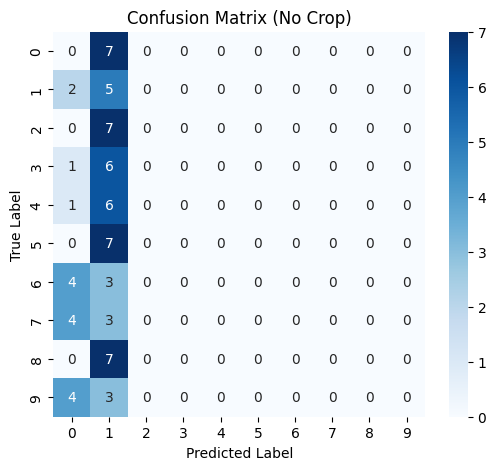

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# คำนวณ Confusion Matrix
cm = confusion_matrix(true_labels, final_correct
                      )

# ตั้งค่าขนาดของกราฟ
plt.figure(figsize=(6, 5))

# ใช้ Seaborn ในการวาด heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))

# ตั้งชื่อแกน
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (No Crop)")

# แสดงผล
plt.show()
